In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# IMPORT LIBRARIES/DATASETS

In [2]:
# Import the necessary packages

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import PIL
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import *
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from IPython.display import display
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


In [3]:
datafolder = "/content/drive/MyDrive/FY_BTech_Project/data"
os.chdir("/content/drive/MyDrive/FY_BTech_Project")

In [4]:
# Check the number of images in the dataset
data = []
label = []

# os.listdir returns the list of files in the folder, in this case image class names
for i in os.listdir(datafolder):
  train_class = os.listdir(os.path.join('data', i))
  for j in train_class:
    img = os.path.join('data', i, j)
    data.append(img)
    label.append(i)

print('Number of train images : {} \n'.format(len(data)))


Number of train images : 3662 



# PERFORM DATA EXPLORATION AND DATA VISUALIZATION

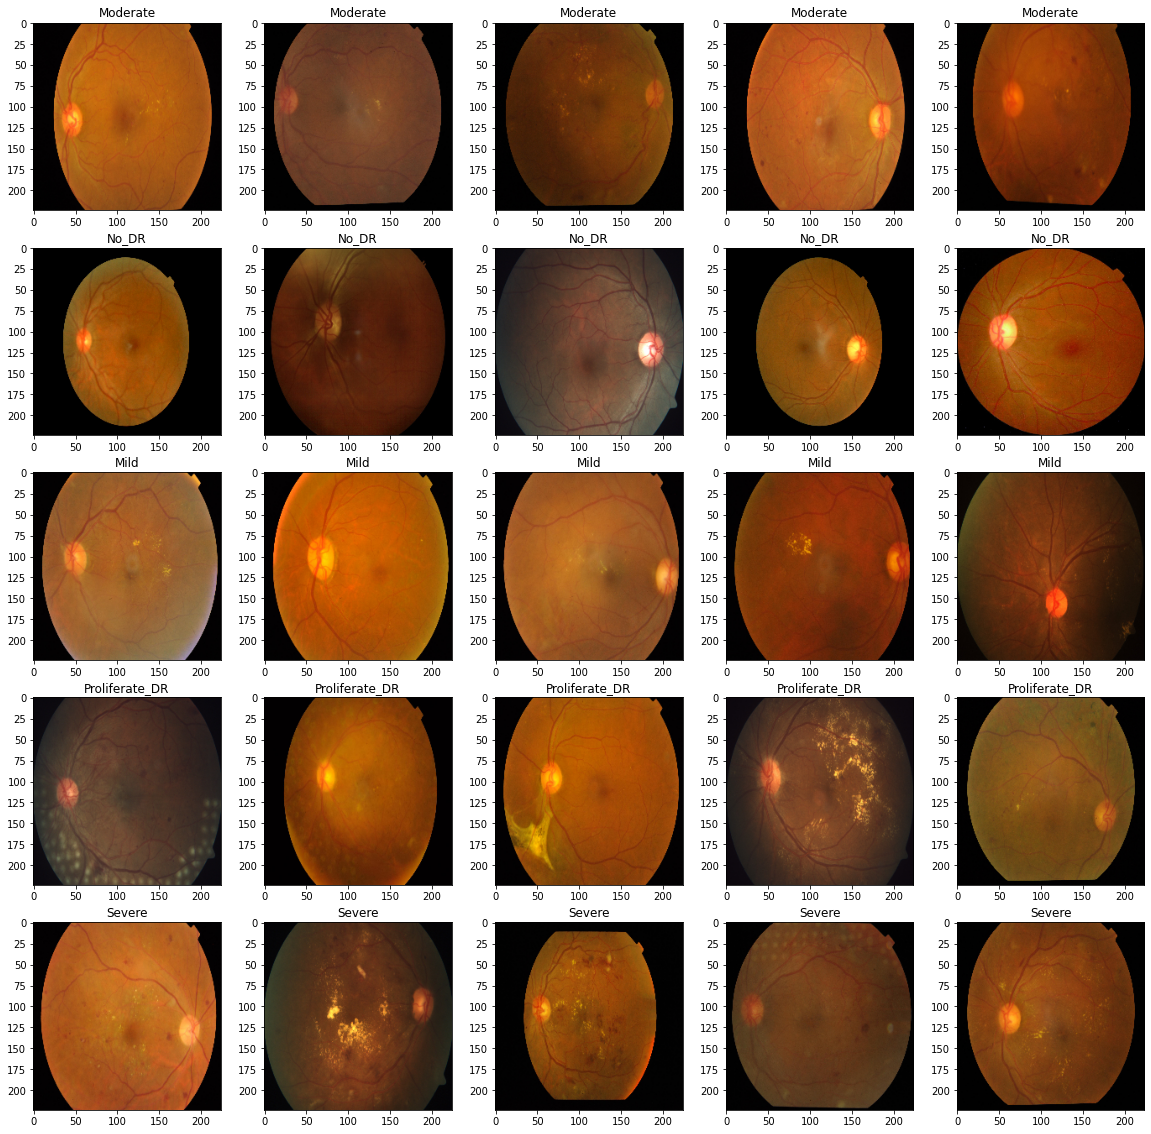

In [5]:
# Visualize 5 images for each class in the dataset

fig, axs = plt.subplots(5, 5, figsize = (20, 20))
count = 0
for i in os.listdir(datafolder):
  # get the list of images in a given class
  train_class = os.listdir(os.path.join('data', i))
  # plot 5 images per class
  for j in range(5):
    img = os.path.join('data', i, train_class[j])
    img = PIL.Image.open(img)
    axs[count][j].title.set_text(i)
    axs[count][j].imshow(img)  
  count += 1



In [6]:
# check the number of images in each class in the training dataset

No_images_per_class = []
Class_name = []
total = 0;
for i in os.listdir(datafolder):
  train_class = os.listdir(os.path.join('data', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))
  total+=len(train_class)  
print("\n\tNumber of total images = {}".format(total))

Number of images in Moderate = 999 

Number of images in No_DR = 1805 

Number of images in Mild = 370 

Number of images in Proliferate_DR = 295 

Number of images in Severe = 193 


	Number of total images = 3662


In [7]:
retina_df = pd.DataFrame({'Image': data,'Labels': label})
retina_df

,Image,Labels
0,data/Moderate/0afdfe5f422c.png,Moderate
1,data/Moderate/064af6592ba6.png,Moderate
2,data/Moderate/0a1076183736.png,Moderate
3,data/Moderate/0af296d2f04a.png,Moderate
4,data/Moderate/01c7808d901d.png,Moderate
...,...,...
3657,data/Severe/762d6e5d5068.png,Severe
3658,data/Severe/c67117c6ab3b.png,Severe
3659,data/Severe/f5a8c6426a71.png,Severe
3660,data/Severe/916ec976ff30.png,Severe


# PERFORM DATA AUGMENTATION AND CREATE DATA GENERATOR

In [14]:
# Shuffle the data and split it into training and testing
retina_df = shuffle(retina_df)
train, test = train_test_split(retina_df, test_size = 0.2, random_state=42)

In [15]:
# Create run-time augmentation on training and test dataset
# For training datagenerator, we add normalization, shear angle, zooming range and horizontal flip
#train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, validation_split = 0.2)

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split = 0.20)

# For test datagenerator, we only normalize the data.
test_datagen = ImageDataGenerator(rescale = 1./255)

In [16]:
# Creating datagenerator for training, validation and test dataset.

train_generator = train_datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    subset='training')

validation_generator = train_datagen.flow_from_dataframe(
    train,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    subset='validation')

test_generator = test_datagen.flow_from_dataframe(
    test,
    directory='./',
    x_col="Image",
    y_col="Labels",
    target_size=(256, 256),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32)

Found 2344 validated image filenames belonging to 5 classes.
Found 585 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


# BUILD RES-BLOCK BASED DEEP LEARNING MODEL

In [11]:
def res_block(X, filter, stage):
  
  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter
    
  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [12]:

input_shape = (256,256,3)

#Input tensor shape
X_input = Input(input_shape)

#Zero-padding

X = ZeroPadding2D((3,3))(X_input)

# 1 - stage

X = Conv2D(64, (9,9), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2- stage

X = res_block(X, filter= [64,64,256], stage= 2)

# 3- stage

X = res_block(X, filter= [128,128,512], stage= 3)

# 4- stage

X = res_block(X, filter= [256,256,1024], stage= 4)

# # 5- stage

# X = res_block(X, filter= [512,512,2048], stage= 5)

#Max Pooling

#X = MaxPooling2D((2,2), strides=(2,2), padding="valid", name = 'Maximum_Pooling')(X)
X = AveragePooling2D((2,2), strides=(2,2), name = 'Avg_Pooling')(X)

#Final layer

X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)


model = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 127, 127, 64  15616       ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                           

# COMPILE AND TRAIN DEEP LEARNING MODEL

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
#using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='accuracy', mode='auto', verbose=1, patience=50)

#save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/FY_BTech_Project/Saved Models/final_resnet_multiclass.h5", verbose = 1, save_best_only=True)

In [ ]:
history = model.fit(train_generator, steps_per_epoch = train_generator.n // 32, epochs = 100, validation_data= validation_generator, validation_steps= validation_generator.n // 32, callbacks=[checkpointer , earlystopping])

Epoch 1/100
66/66 [==============================] - ETA: 0s - loss: 1.9245 - accuracy: 0.5823
Epoch 1: val_loss improved from inf to 2.17950, saving model to /content/drive/MyDrive/FY_BTech_Project/Saved Models/final_resnet_multiclass.h5
66/66 [==============================] - 48s 682ms/step - loss: 1.9245 - accuracy: 0.5823 - val_loss: 2.1795 - val_accuracy: 0.1035
Epoch 2/100
66/66 [==============================] - ETA: 0s - loss: 1.0112 - accuracy: 0.6569
Epoch 2: val_loss improved from 2.17950 to 2.17497, saving model to /content/drive/MyDrive/FY_BTech_Project/Saved Models/final_resnet_multiclass.h5
66/66 [==============================] - 43s 656ms/step - loss: 1.0112 - accuracy: 0.6569 - val_loss: 2.1750 - val_accuracy: 0.2617
Epoch 3/100
66/66 [==============================] - ETA: 0s - loss: 0.9188 - accuracy: 0.6716
Epoch 3: val_loss did not improve from 2.17497
66/66 [==============================] - 42s 633ms/step - loss: 0.9188 - accuracy: 0.6716 - val_loss: 2.3949 - v

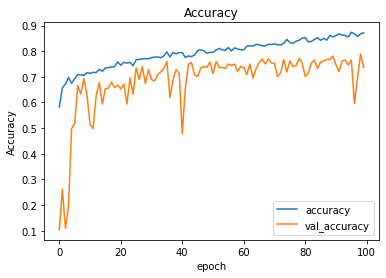

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy','val_accuracy'], loc = 'lower right')
plt.show()


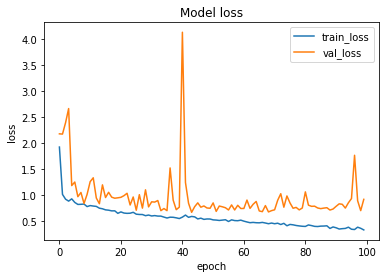

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()


# ASSESS THE PERFORMANCE OF THE TRAINED MODEL

In [17]:
# Evaluate the performance of the model
from keras.models import load_model
saved_model = load_model("/content/drive/MyDrive/FY Project/Final Final Models/multiclass.h5")
evaluate = saved_model.evaluate(test_generator, steps = test_generator.n // 32, verbose =1)
#evaluate2 = saved_model.evaluate(validation_generator, steps = validation_generator.n // 32, verbose =1)

22/22 [==============================] - 463s 22s/step - loss: 0.5101 - accuracy: 0.8011


In [18]:
print('Accuracy Test : {:.4f} %'.format(evaluate[1]*100))
print('Loss Test : {:.4f}'.format(evaluate[0]))
#print('Accuracy validation : {:.4f} %'.format(evaluate2[1]*100))
#print('Loss validation : {:.4f}'.format(evaluate2[0]))

Accuracy Test : 80.1136 %
Loss Test : 0.5101


In [19]:
# Assigning label names to the corresponding indexes
labels = {0: 'Mild', 1: 'Moderate', 2: 'No_DR', 3:'Proliferate_DR', 4: 'Severe'}

In [ ]:
# Loading images and their predictions 

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# import cv2

prediction = []
original = []
image = []
count = 0

for item in range(len(test)):
  # code to open the image
  img= PIL.Image.open(test['Image'].tolist()[item])
  # resizing the image to (256,256)
  img = img.resize((256,256))
  # appending image to the image list
  image.append(img)
  # converting image to array
  img = np.asarray(img, dtype= np.float32)
  # normalizing the image
  img = img / 255
  # reshaping the image in to a 4D array
  img = img.reshape(-1,256,256,3)
  # making prediction of the model
  predict = saved_model.predict(img)
  # getting the index corresponding to the highest value in the prediction
  predict = np.argmax(predict)
  # appending the predicted class to the list
  prediction.append(labels[predict])
  # appending original class to the list
  original.append(test['Labels'].tolist()[item])


1/1 [==============================] - 0s 18ms/step


In [ ]:
'''from keras.engine.data_adapter import train_validation_split
# Loading images and their predictions 

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# import cv2

prediction = []
original = []
image = []
count = 0

for item in range(len(validation_generator)):
  # code to open the image
  img= PIL.Image.open(train['Image'].tolist()[item])
  # resizing the image to (256,256)
  img = img.resize((256,256))
  # appending image to the image list
  image.append(img)
  # converting image to array
  img = np.asarray(img, dtype= np.float32)
  # normalizing the image
  img = img / 255
  # reshaping the image in to a 4D array
  img = img.reshape(-1,256,256,3)
  # making prediction of the model
  predict = saved_model.predict(img)
  # getting the index corresponding to the highest value in the prediction
  predict = np.argmax(predict)
  # appending the predicted class to the list
  prediction.append(labels[predict])
  # appending original class to the list
  original.append(test['Labels'].tolist()[item])
'''

In [ ]:
# Getting the test accuracy 
score = accuracy_score(original, prediction)
print("Test Accuracy : {:.4f} %".format(score*100))

In [ ]:
# Visualizing the results
import random
fig=plt.figure(figsize = (100,100))
for i in range(30):
    j = random.randint(0,len(image))
    fig.add_subplot(30, 1, i+1)
    plt.xlabel("Prediction: " + prediction[j] +"   Original: " + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import roc_curve,auc
print(classification_report(np.asarray(original), np.asarray(prediction)))

                precision    recall  f1-score   support

          Mild       0.70      0.38      0.50        73
      Moderate       0.62      0.90      0.74       194
         No_DR       0.95      0.99      0.97       360
Proliferate_DR       0.69      0.42      0.52        60
        Severe       1.00      0.07      0.12        46

      accuracy                           0.80       733
     macro avg       0.79      0.55      0.57       733
  weighted avg       0.82      0.80      0.77       733



Text(0.5, 1.0, 'Confusion_matrix')

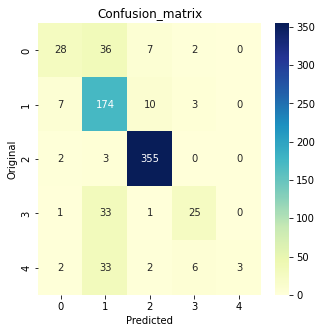

In [ ]:
import seaborn as sns
plt.figure(figsize = (5,5))
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax, cmap="YlGnBu",fmt = "g")

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')

In [ ]:
FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
sensitivity = (TP/(TP + FN))
specificity = (TN/(TN + FP))

print("Sensitivity : "+str(sensitivity[0]))
print("Specificity : "+str(specificity[0]))

Sensitivity : 0.3835616438356164
Specificity : 0.9818181818181818


In [ ]:
'''from sklearn.metrics import roc_auc_score
list1=[]
list2=[]

for i in original:
    if(i == "No_DR"):
        list1.append(0)
    elif(i == "Mild"):
        list1.append(1)
    elif(i == "Moderate"):
        list1.append(2)
    elif(i == "Severe"):
        list1.append(3)
    elif(i == "Proliferate"):
        list1.append(4)
    else:
        pass
for i in prediction:
    if(i == "No_DR"):
        list2.append(0)
    elif(i == "Mild"):
        list2.append(1)
    elif(i == "Moderate"):
        list2.append(2)
    elif(i == "Severe"):
        list2.append(3)
    elif(i == "Proliferate"):
        list2.append(4)
    else:
        pass

auc = roc_auc_score(list1,list2,multi_class='ovo',average="macro")
print('ROC AUC: %.4f' % auc)'''

'from sklearn.metrics import roc_auc_score\nlist1=[]\nlist2=[]\n\nfor i in original:\n    if(i == "No_DR"):\n        list1.append(0)\n    elif(i == "Mild"):\n        list1.append(1)\n    elif(i == "Moderate"):\n        list1.append(2)\n    elif(i == "Severe"):\n        list1.append(3)\n    elif(i == "Proliferate"):\n        list1.append(4)\n    else:\n        pass\nfor i in prediction:\n    if(i == "No_DR"):\n        list2.append(0)\n    elif(i == "Mild"):\n        list2.append(1)\n    elif(i == "Moderate"):\n        list2.append(2)\n    elif(i == "Severe"):\n        list2.append(3)\n    elif(i == "Proliferate"):\n        list2.append(4)\n    else:\n        pass\n\nauc = roc_auc_score(list1,list2,multi_class=\'ovo\',average="macro")\nprint(\'ROC AUC: %.4f\' % auc)'

In [ ]:
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
def multiclass_roc_auc_score(list1, list2, average="macro"):
  lb = preprocessing.LabelBinarizer()
  lb.fit(list1)
  list1 = lb.transform(list1)
  list2 = lb.transform(list2)
  return roc_auc_score(list1, list2, average=average)

In [ ]:
print("AUC score: ",multiclass_roc_auc_score(original,prediction))

AUC score:  0.7465512988365071
